In [1]:
# use SAM model to segment the image

import os
import pickle
import cv2
import torch
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry

from utils import (
    show_mask, show_box, get_device, pixel_accuracy,
    iou_score, dice_score, f1_score
)

# !wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [2]:
device = get_device()

sam_checkpoint = "/Users/naman/Workspace/Data/BM5020-POEM/sam_vit_h_4b8939.pth"
# sam_checkpoint = "/home/pradeep/Documents/IITH_Academics/sem-6/AI in Biomedicine and Healthcare/BM5020-Project/sam_vit_h_4b8939.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

predictor = SamPredictor(sam)

In [3]:
im_dir = "/Users/naman/Workspace/Data/BM5020-POEM/Annotated"
im_filenames = [
    im_file for im_file in os.listdir(im_dir)
    if os.path.splitext(im_file)[1] == ".jpg"
]
filenames_iter = iter(im_filenames)

im_filenames

['M_01022024131810_20698051_1_001_0001-01.MP4-frame7130.jpg',
 'M_01112024131028_20696889_1_001_0002-01.MP4-frame5946.jpg',
 'M_01022024131810_20698051_1_001_0002-01.MP4-frame58581.jpg',
 'M_01092024123848_20698524_1_001_0001-01.MP4-frame49654.jpg',
 '8.jpg',
 'M_01022024131810_20698051_1_001_0001-01.MP4-frame6389.jpg',
 'M_01022024131810_20698051_1_001_0002-01.MP4-frame61918.jpg',
 '9.jpg',
 'M_01022024131810_20698051_1_001_0002-01.MP4-frame68805.jpg',
 'M_01022024131810_20698051_1_001_0001-01.MP4-frame7780.jpg',
 'M_01022024131810_20698051_1_001_0001-01.MP4-frame5791.jpg',
 'M_01092024123848_20698524_1_001_0001-01.MP4-frame23206.jpg',
 'M_01022024131810_20698051_1_001_0002-01.MP4-frame7603.jpg',
 'M_01022024131810_20698051_1_001_0001-01.MP4-frame10874.jpg',
 'M_01092024123848_20698524_1_001_0001-01.MP4-frame26744.jpg',
 '10.jpg',
 'M_01112024131028_20696889_1_001_0002-01.MP4-frame8762.jpg',
 'M_01112024131028_20696889_1_001_0002-01.MP4-frame7530.jpg',
 'M_01022024131810_20698051_1_00

In [4]:
pkl_path = f"{im_dir}/annotations.pkl"

with open(pkl_path, "rb") as file:
    all_masks = pickle.load(file)

len(all_masks)

19

---

M_01022024131810_20698051_1_001_0001-01.MP4-frame6389.jpg
False


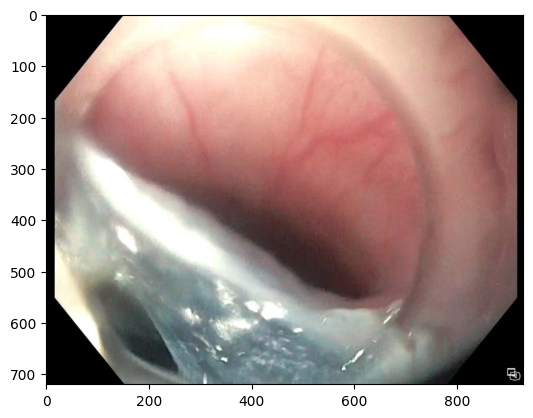

In [5]:
filename = next(filenames_iter)
while filename in all_masks.keys():
    filename = next(filenames_iter)

print(filename, filename in all_masks.keys(), sep="\n")
image = cv2.imread(f"{im_dir}/{filename}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [6]:
image.shape

(720, 930, 3)

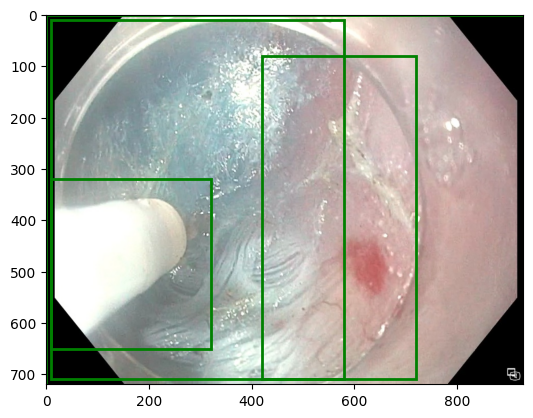

In [75]:
input_boxes = torch.tensor([

    # 0 - Background (Null class)
    [0, 0, *image.shape[-2::-1]],

    # 1 - Muscle layer
    [420, 80, 720, 710],

    # 2 - Mucosal layer
    [10, 10, 580, 710],

    # 3 - Electrode
    [10, 320, 320, 650]

]).to(device)

plt.imshow(image)
for box in input_boxes:
    show_box(box.cpu(), plt.gca())
plt.show()

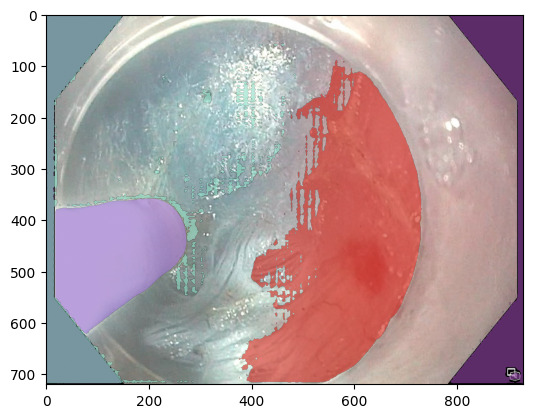

In [76]:
predictor.set_image(image)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
plt.show()

In [77]:
all_masks[filename] = masks.squeeze().argmax(0).cpu()

print(len(all_masks))

30


---

In [72]:
masks[:, 0, 350, 400]

tensor([False, False,  True, False], device='mps:0')

In [217]:
with open(pkl_path, "wb") as file:
    pickle.dump(all_masks, file)